# Applying logistic regression in python to discriminate between control and M. bovis infected animals using peripheral blood transcriptomics data from kirsten et al., 2021
### This analysis considers two approaches, one using logistic regression on variable genes that have been preprocessed using DESeq2 (vst normalised) and the other using latent variables inferred using PCA, ICA and NMF

In [108]:
## Load in all necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

from scipy import stats
from scipy.stats import kurtosis

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay,roc_curve,auc, make_scorer,mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, GridSearchCV, cross_val_score, PredefinedSplit
from sklearn.decomposition import PCA, NMF, FastICA
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.pipeline import Pipeline
import warnings
import pickle
from sklearn.pipeline import Pipeline
warnings.filterwarnings('ignore')

#font for plots
font = {'fontname':'Arial'}

In [109]:
kirsten_data_raw = pd.read_csv("/home/workspace/jogrady/ML4TB/work/normalisation/vst_individual/kirsten_vst_normalised_data.txt", sep = "\t").T


In [132]:
kirsten_data_raw = pd.read_csv("/home/workspace/jogrady/ML4TB/work/normalisation/vst_individual/kirsten_vst_normalised_data.txt", sep = "\t").T
kirsten_labels = pd.read_csv("/home/workspace/jogrady/ML4TB/data/kirsten/kirsten_samples.csv", sep = "\t")
kirsten_labels = kirsten_labels[["Animal_Code", "Week", "Status"]].drop_duplicates()
np.array(kirsten_labels["Animal_Code"]) == np.array(kirsten_data_raw.index)
kirsten_labels["ID"] = kirsten_labels["Animal_Code"].str.extract(r"(A\d{4})", expand=False)
kirsten_labels["Fold"] = kirsten_labels.groupby("ID").ngroup()
# Check right order
np.array(kirsten_labels["Animal_Code"]) == np.array(kirsten_data_raw.index)

kirsten_labels_simple = kirsten_labels["Status"].to_numpy()
kirsten_folds = kirsten_labels["Fold"].to_numpy()


kirsten_labels_simple = np.where(kirsten_labels_simple == "Control", 0, np.where(kirsten_labels_simple == "Infected", 1, kirsten_labels_simple))
kirsten_labels_simple = kirsten_labels_simple.astype(int)

In [133]:
# Calcualte variances for VST normalised genes
variances = kirsten_data_raw.var(axis=0)
# take top 20% and filter
threshold = variances.quantile(.80) 
genes = variances > threshold
genes= genes.loc[genes==True].index
kirsten_data = kirsten_data_raw.filter(items = genes, axis=1)

In [134]:
kirsten_data.head()

,SMIM11,ZBTB21,ITSN1,ABCG1,TFF2,TMPRSS3,RSPH1,IL1RAP,SLC37A1,P3H2,...,ENSBTAG00000054086,ENSBTAG00000050585,ENSBTAG00000052194,ENSBTAG00000053934,SERPINB4,ENSBTAG00000050153,ENSBTAG00000052012,MAD2L1,ENSBTAG00000054081,ENSBTAG00000049569
A6511_W-1,6.966160,8.037194,8.752079,9.421209,5.665151,5.263419,5.339643,9.156109,9.298534,5.521635,...,6.470850,5.859099,5.665151,6.734723,6.346728,5.748045,5.053554,7.354211,5.786630,6.583270
A6514_W-1,7.530962,7.530962,8.413710,9.466724,4.764618,4.764618,5.249967,7.779656,9.064442,5.501468,...,6.428989,5.863985,6.121726,6.503596,5.795944,5.551156,4.764618,7.237631,5.722225,5.249967
A6520_W-1,6.977538,7.692023,8.622618,9.638544,5.473673,5.034926,5.422001,8.295739,9.161759,6.252824,...,6.231887,5.791248,5.608571,6.231887,5.146336,5.942270,4.764618,7.302223,5.302897,5.608571
A6526_W-1,7.369448,7.936618,8.616556,9.603629,5.136714,4.764618,5.663960,7.974058,9.548575,5.766236,...,6.257961,5.028093,5.733513,6.387568,5.828215,4.764618,5.219716,7.530778,5.350551,6.581071
A6635_W-1,7.252932,7.870503,8.601384,8.891924,6.252159,5.554408,5.897229,8.982321,9.372737,5.294756,...,6.402719,6.004498,5.635428,6.551778,5.776164,5.743141,4.764618,7.323582,5.672943,6.291702


In [135]:
# Convert the custom folds array to a PredefinedSplit object
ps = PredefinedSplit(test_fold=kirsten_folds)

In [136]:

# Make a pipeline for logistic regression and set the paramaters
log_pipe = Pipeline(steps=[
('scaler', StandardScaler()), # see comment above (in markdown)
('classifier', LogisticRegression(max_iter=10000, solver='saga', tol=0.0001, random_state=42))]) # classifier

precision_scorer = make_scorer(precision_score, zero_division=1)  # had to modify zero_division as it was giving problems
f1_scorer = make_scorer(f1_score)
accuracy_scorer = make_scorer(accuracy_score)
recall_scorer = make_scorer(recall_score)

# Define scoring dictionary for GridSearchCV
scoring = {
    'accuracy': accuracy_scorer,
    'f1': f1_scorer,
    'precision': precision_scorer,
    'recall': recall_scorer
}

# Create a parameter grid - we will search through all these combinations
param_grid = {
    'classifier__penalty': ["elasticnet"],
    'classifier__l1_ratio': [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
}
 
# Create GridSearchCV object
grid_search = GridSearchCV(log_pipe, param_grid, cv=ps, verbose=3, n_jobs=60, scoring=scoring, refit="accuracy")

In [137]:
grid_search.fit(kirsten_data, kirsten_labels_simple)

Fitting 9 folds for each of 10 candidates, totalling 90 fits
[CV 2/9] END classifier__l1_ratio=0.1, classifier__penalty=elasticnet; accuracy: (test=0.667) f1: (test=0.750) precision: (test=1.000) recall: (test=0.600) total time=  14.8s
[CV 2/9] END classifier__l1_ratio=0.3, classifier__penalty=elasticnet; accuracy: (test=1.000) f1: (test=1.000) precision: (test=1.000) recall: (test=1.000) total time=  15.1s
[CV 1/9] END classifier__l1_ratio=0.7, classifier__penalty=elasticnet; accuracy: (test=0.833) f1: (test=0.889) precision: (test=1.000) recall: (test=0.800) total time=  15.2s
[CV 3/9] END classifier__l1_ratio=0.3, classifier__penalty=elasticnet; accuracy: (test=0.400) f1: (test=0.400) precision: (test=1.000) recall: (test=0.250) total time=  16.7s
[CV 6/9] END classifier__l1_ratio=0.1, classifier__penalty=elasticnet; accuracy: (test=0.667) f1: (test=0.750) precision: (test=1.000) recall: (test=0.600) total time=  21.0s
[CV 8/9] END classifier__l1_ratio=0.2, classifier__penalty=elast

GridSearchCV(cv=PredefinedSplit(test_fold=array([0, 1, 2, 3, 4, 5, 6, 7, 8, 0, 1, 2, 3, 4, 5, 6, 7, 8, 0, 1, 4, 5,
       6, 7, 8, 0, 1, 2, 3, 4, 5, 6, 7, 8, 0, 1, 2, 3, 4, 5, 6, 7, 8, 0,
       1, 2, 3, 4, 5, 6, 7, 8])),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('classifier',
                                        LogisticRegression(max_iter=10000,
                                                           random_state=42,
                                                           solver='saga'))]),
             n_jobs=60,
             param_grid={'classifier__l1_ratio': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6,
                                                  0.7, 0.8, 0.9, 1],
                         'classifier__penalty': ['elasticnet']},
             refit='accuracy',
             scoring={'accuracy': make_scorer(accuracy_score),
                      'f1': make_scorer(f1_score),
                      'precision': make_scorer(precision_score, zero_division=1),
                      'recall': make_scorer(recall_score)},
             verbose=3)

In [138]:
# Look at best paramaters and accuracy and save results to a data frame
print("Best Parameters:", grid_search.best_params_)
print(f"Best CV average accuracy: {grid_search.best_score_:.3f}")
results_genes = pd.concat([pd.DataFrame(grid_search.cv_results_["params"]),
           pd.DataFrame(grid_search.cv_results_["mean_test_accuracy"], columns = ["Average Accuracy"]),
           pd.DataFrame(grid_search.cv_results_["std_test_accuracy"], columns=["SD accuracy"]),
           pd.DataFrame(grid_search.cv_results_["mean_test_precision"], columns = ["Average precision"]),
           pd.DataFrame(grid_search.cv_results_["std_test_precision"], columns=["SD precision"]),
           pd.DataFrame(grid_search.cv_results_["mean_test_recall"], columns=["Average recall"]),
           pd.DataFrame(grid_search.cv_results_["std_test_recall"], columns=["SD recall"])],axis=1)
results_genes.sort_values(by='Average Accuracy', inplace=True)

Best Parameters: {'classifier__l1_ratio': 0.9, 'classifier__penalty': 'elasticnet'}
Best CV average accuracy: 0.944


In [140]:
results_genes
results_models = pd.DataFrame(grid_search.cv_results_)
results_models.sort_values(by='rank_test_accuracy', inplace=True)
results_genes

,classifier__l1_ratio,classifier__penalty,Average Accuracy,SD accuracy,Average precision,SD precision,Average recall,SD recall
0,0.1,elasticnet,0.729630,0.224128,1.000000,0.000000,0.672222,0.273974
1,0.2,elasticnet,0.748148,0.225044,1.000000,0.000000,0.694444,0.275322
3,0.4,elasticnet,0.822222,0.198139,0.981481,0.052378,0.805556,0.254345
2,0.3,elasticnet,0.840741,0.205947,1.000000,0.000000,0.805556,0.254345
4,0.5,elasticnet,0.862963,0.143539,0.981481,0.052378,0.855556,0.183249
6,0.7,elasticnet,0.907407,0.114156,0.962963,0.069290,0.933333,0.133333
5,0.6,elasticnet,0.925926,0.114156,0.981481,0.052378,0.933333,0.133333
7,0.8,elasticnet,0.925926,0.082817,0.962963,0.069290,0.955556,0.083148
8,0.9,elasticnet,0.944444,0.078567,0.962963,0.069290,0.977778,0.062854
9,1.0,elasticnet,0.944444,0.078567,0.962963,0.069290,0.977778,0.062854


In [142]:
data_test = pd.DataFrame(zip(kirsten_data.columns, np.transpose(grid_search.best_estimator_.named_steps["classifier"].coef_)), columns=['features', 'coef'])#.sort_values(by='coef', inplace=True)
data_test.sort_values(by='coef', inplace = True)
data_test = data_test.loc[(data_test != 0).all(axis=1), :]
data_test.shape

(96, 2)

# PCA

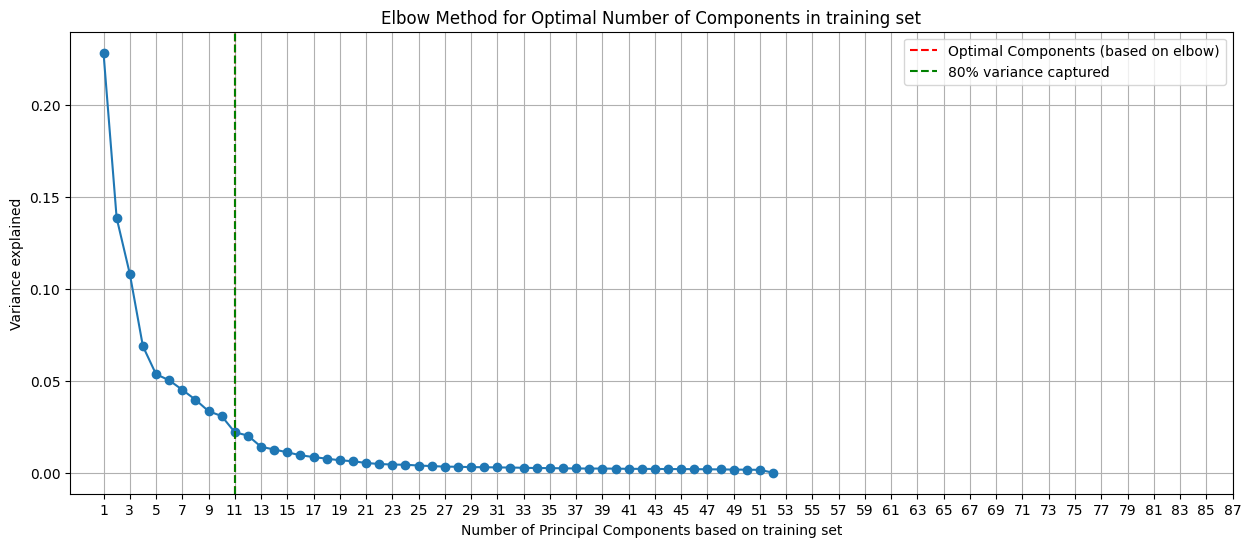

Variance captured by 11 PCs:0.82


In [158]:
 
# Do not need to scale for PCA - not recommended in VST
pca = PCA(random_state=88, n_components=52)
pca.fit(kirsten_data)
explained_variance = pca.explained_variance_ratio_
# Plotting the elbow curve
plt.figure(figsize=(15, 6))
plt.plot(range(1, 52+1), explained_variance, marker='o')
plt.xlabel('Number of Principal Components based on training set')
plt.ylabel('Variance explained')
plt.title('Elbow Method for Optimal Number of Components in training set')
plt.grid()
plt.xticks(range(1, 87 + 1,2))
plt.axvline(x=11, color='r', linestyle='--', label='Optimal Components (based on elbow)')
plt.axvline(x=11, color='g', linestyle='--', label='80% variance captured')
plt.legend()
plt.show()
print(f'Variance captured by 11 PCs:{pca.explained_variance_ratio_[:11].sum():.2f}')

In [163]:
# Set up the pipeline
PCA_Pipeline = Pipeline(steps=[('pca', PCA(random_state=42)),
('classifier', LogisticRegression(max_iter=10000, penalty="none", solver='saga', tol=0.0001, random_state=42))])

# Set up a grid for each PC
pca_param_grid = {'pca__n_components': list(range(1, 12))}

# Apply
LR_pca_search_model = GridSearchCV(PCA_Pipeline, pca_param_grid, cv=ps, scoring=scoring, refit="accuracy")

# Fit
LR_pca_search_model.fit(kirsten_data, kirsten_labels_simple.ravel())

GridSearchCV(cv=PredefinedSplit(test_fold=array([0, 1, 2, 3, 4, 5, 6, 7, 8, 0, 1, 2, 3, 4, 5, 6, 7, 8, 0, 1, 4, 5,
       6, 7, 8, 0, 1, 2, 3, 4, 5, 6, 7, 8, 0, 1, 2, 3, 4, 5, 6, 7, 8, 0,
       1, 2, 3, 4, 5, 6, 7, 8])),
             estimator=Pipeline(steps=[('pca', PCA(random_state=42)),
                                       ('classifier',
                                        LogisticRegression(max_iter=10000,
                                                           penalty='none',
                                                           random_state=42,
                                                           solver='saga'))]),
             param_grid={'pca__n_components': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10,
                                               11]},
             refit='accuracy',
             scoring={'accuracy': make_scorer(accuracy_score),
                      'f1': make_scorer(f1_score),
                      'precision': make_scorer(precision_score, zero_division=1),
                      'recall': make_scorer(recall_score)})

In [164]:
# Look at best paramaters and accuracy and save results to a data frame
print(f"Best Paramater:", LR_pca_search_model.best_params_)
print(f"Best Score: {LR_pca_search_model.best_score_:.2f}")
results_pca = pd.concat([pd.DataFrame(LR_pca_search_model.cv_results_["params"]),
           pd.DataFrame(LR_pca_search_model.cv_results_["mean_test_accuracy"], columns = ["CV Accuracy"]),
           pd.DataFrame(LR_pca_search_model.cv_results_["std_test_accuracy"], columns=["SD accuracy"]),
           pd.DataFrame(LR_pca_search_model.cv_results_["mean_test_precision"], columns = ["CV precision"]),
           pd.DataFrame(LR_pca_search_model.cv_results_["std_test_precision"], columns=["SD precision"]),
           pd.DataFrame(LR_pca_search_model.cv_results_["mean_test_recall"], columns=["CV recall"]),
           pd.DataFrame(LR_pca_search_model.cv_results_["std_test_recall"], columns=["SD recall"])],axis=1)
results_pca.sort_values(by='CV Accuracy', inplace=True)

Best Paramater: {'pca__n_components': 9}
Best Score: 0.92


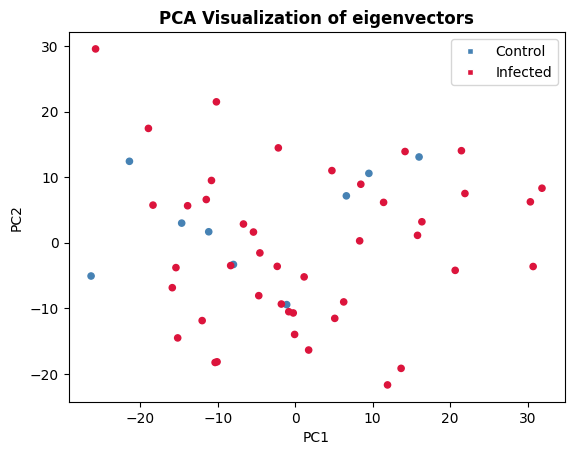

,Component_1,Component_2,Component_3,Component_4,Component_5,Component_6,Component_7,Component_8,Component_9,Component_10,Component_11
0,STEAP4,ENSBTAG00000006383,CXCL3,ENSBTAG00000054774,DNER,DNER,FBN1,ENSBTAG00000050515,PRSS2,ENSBTAG00000006383,ENSBTAG00000052270
1,SLC1A1,SLC1A1,CXCL2,ENSBTAG00000009656,ENSBTAG00000037421,ENSBTAG00000032057,ENSBTAG00000026070,ENSBTAG00000054086,RGS2,ENSBTAG00000050398,ENSBTAG00000054241
2,ENSBTAG00000051635,ENSBTAG00000054774,GRO1,ENSBTAG00000052511,CXCL8,ENSBTAG00000053508,ENSBTAG00000032057,ENSBTAG00000039714,CLU,CBLIF,ENSBTAG00000049995
3,ENSBTAG00000053536,ENSBTAG00000053536,PRSS2,ENSBTAG00000052270,CRCP,FBN1,ENSBTAG00000022715,ENSBTAG00000054768,ENSBTAG00000011961,TPM1,ENSBTAG00000053508
4,ENSBTAG00000048577,ADGRV1,PTGS2,CXCL3,CXCL2,CXCL8,ENSBTAG00000052511,ENSBTAG00000050510,ENSBTAG00000054209,RADX,ENSBTAG00000047764
...,...,...,...,...,...,...,...,...,...,...,...
5517,IFI47,NR4A3,KMT2A,ENSBTAG00000045580,BOLA-DQB,ENSBTAG00000054768,ENSBTAG00000050846,HBB,FAT1,LRATD1,SERPINB2
5518,ENSBTAG00000052397,ENSBTAG00000048835,ENSBTAG00000053508,CBLIF,ENSBTAG00000049995,BOLA-DQA5,BOLA-DQA5,ENSBTAG00000053508,ENSBTAG00000024272,CYP2J30,ENSBTAG00000006383
5519,ENSBTAG00000047121,RGS2,ENSBTAG00000037421,BRB,ENSBTAG00000054774,ENSBTAG00000006383,ENSBTAG00000045580,ENSBTAG00000039524,HBA,ENSBTAG00000047449,ENSBTAG00000008328
5520,ENSBTAG00000047529,ENSBTAG00000009656,CRCP,ENSBTAG00000039524,BOLA-DQA5,ENSBTAG00000009656,ENSBTAG00000009656,ENSBTAG00000024272,SULT1C4,ENSBTAG00000037937,SULT1C4


In [171]:
# 'residuals_all.columns' contains the names of the genes

pca = PCA(random_state=42, n_components=30)
pca_fit = pca.fit(kirsten_data)
comp_genes= []
pca_genes = pd.DataFrame()
pca_results = pca_fit.fit_transform(kirsten_data)
colors = ['steelblue' if label == 0 else 'crimson' for label in kirsten_labels_simple.ravel()]
plt.scatter(pca_results[:, 0], pca_results[:, 1], label="Training data", c=colors, s=20)
handles = [plt.Line2D([0], [0], marker='s', color='w', markerfacecolor='steelblue', markersize=5, label='Control'),
           plt.Line2D([0], [0], marker='s', color='w', markerfacecolor='crimson', markersize=5, label='Infected')]
plt.title("PCA Visualization of eigenvectors", fontweight='bold')
plt.legend(handles=handles)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()
# Iterate through each component
for component_idx in range(11):
    # Calculate loadings for the current component
    loadings = pca_fit.components_.T * np.sqrt(pca_fit.explained_variance_)

    # Sort genes by their influence on the current component
    sorted_genes = kirsten_data.columns[np.argsort(loadings[:, component_idx])]

    # Visualize the top N genes that contribute the most to the current component
    N = pca_fit.components_.shape[1]
    top_genes = sorted_genes[-N:]

    pca_genes[component_idx] = top_genes[::-1]
    comp_genes = np.append(comp_genes, top_genes)
pca_genes.columns = ["Component_1","Component_2","Component_3","Component_4",
                     "Component_5","Component_6","Component_7","Component_8",
                     "Component_9","Component_10","Component_11"]                      
pca_genes 

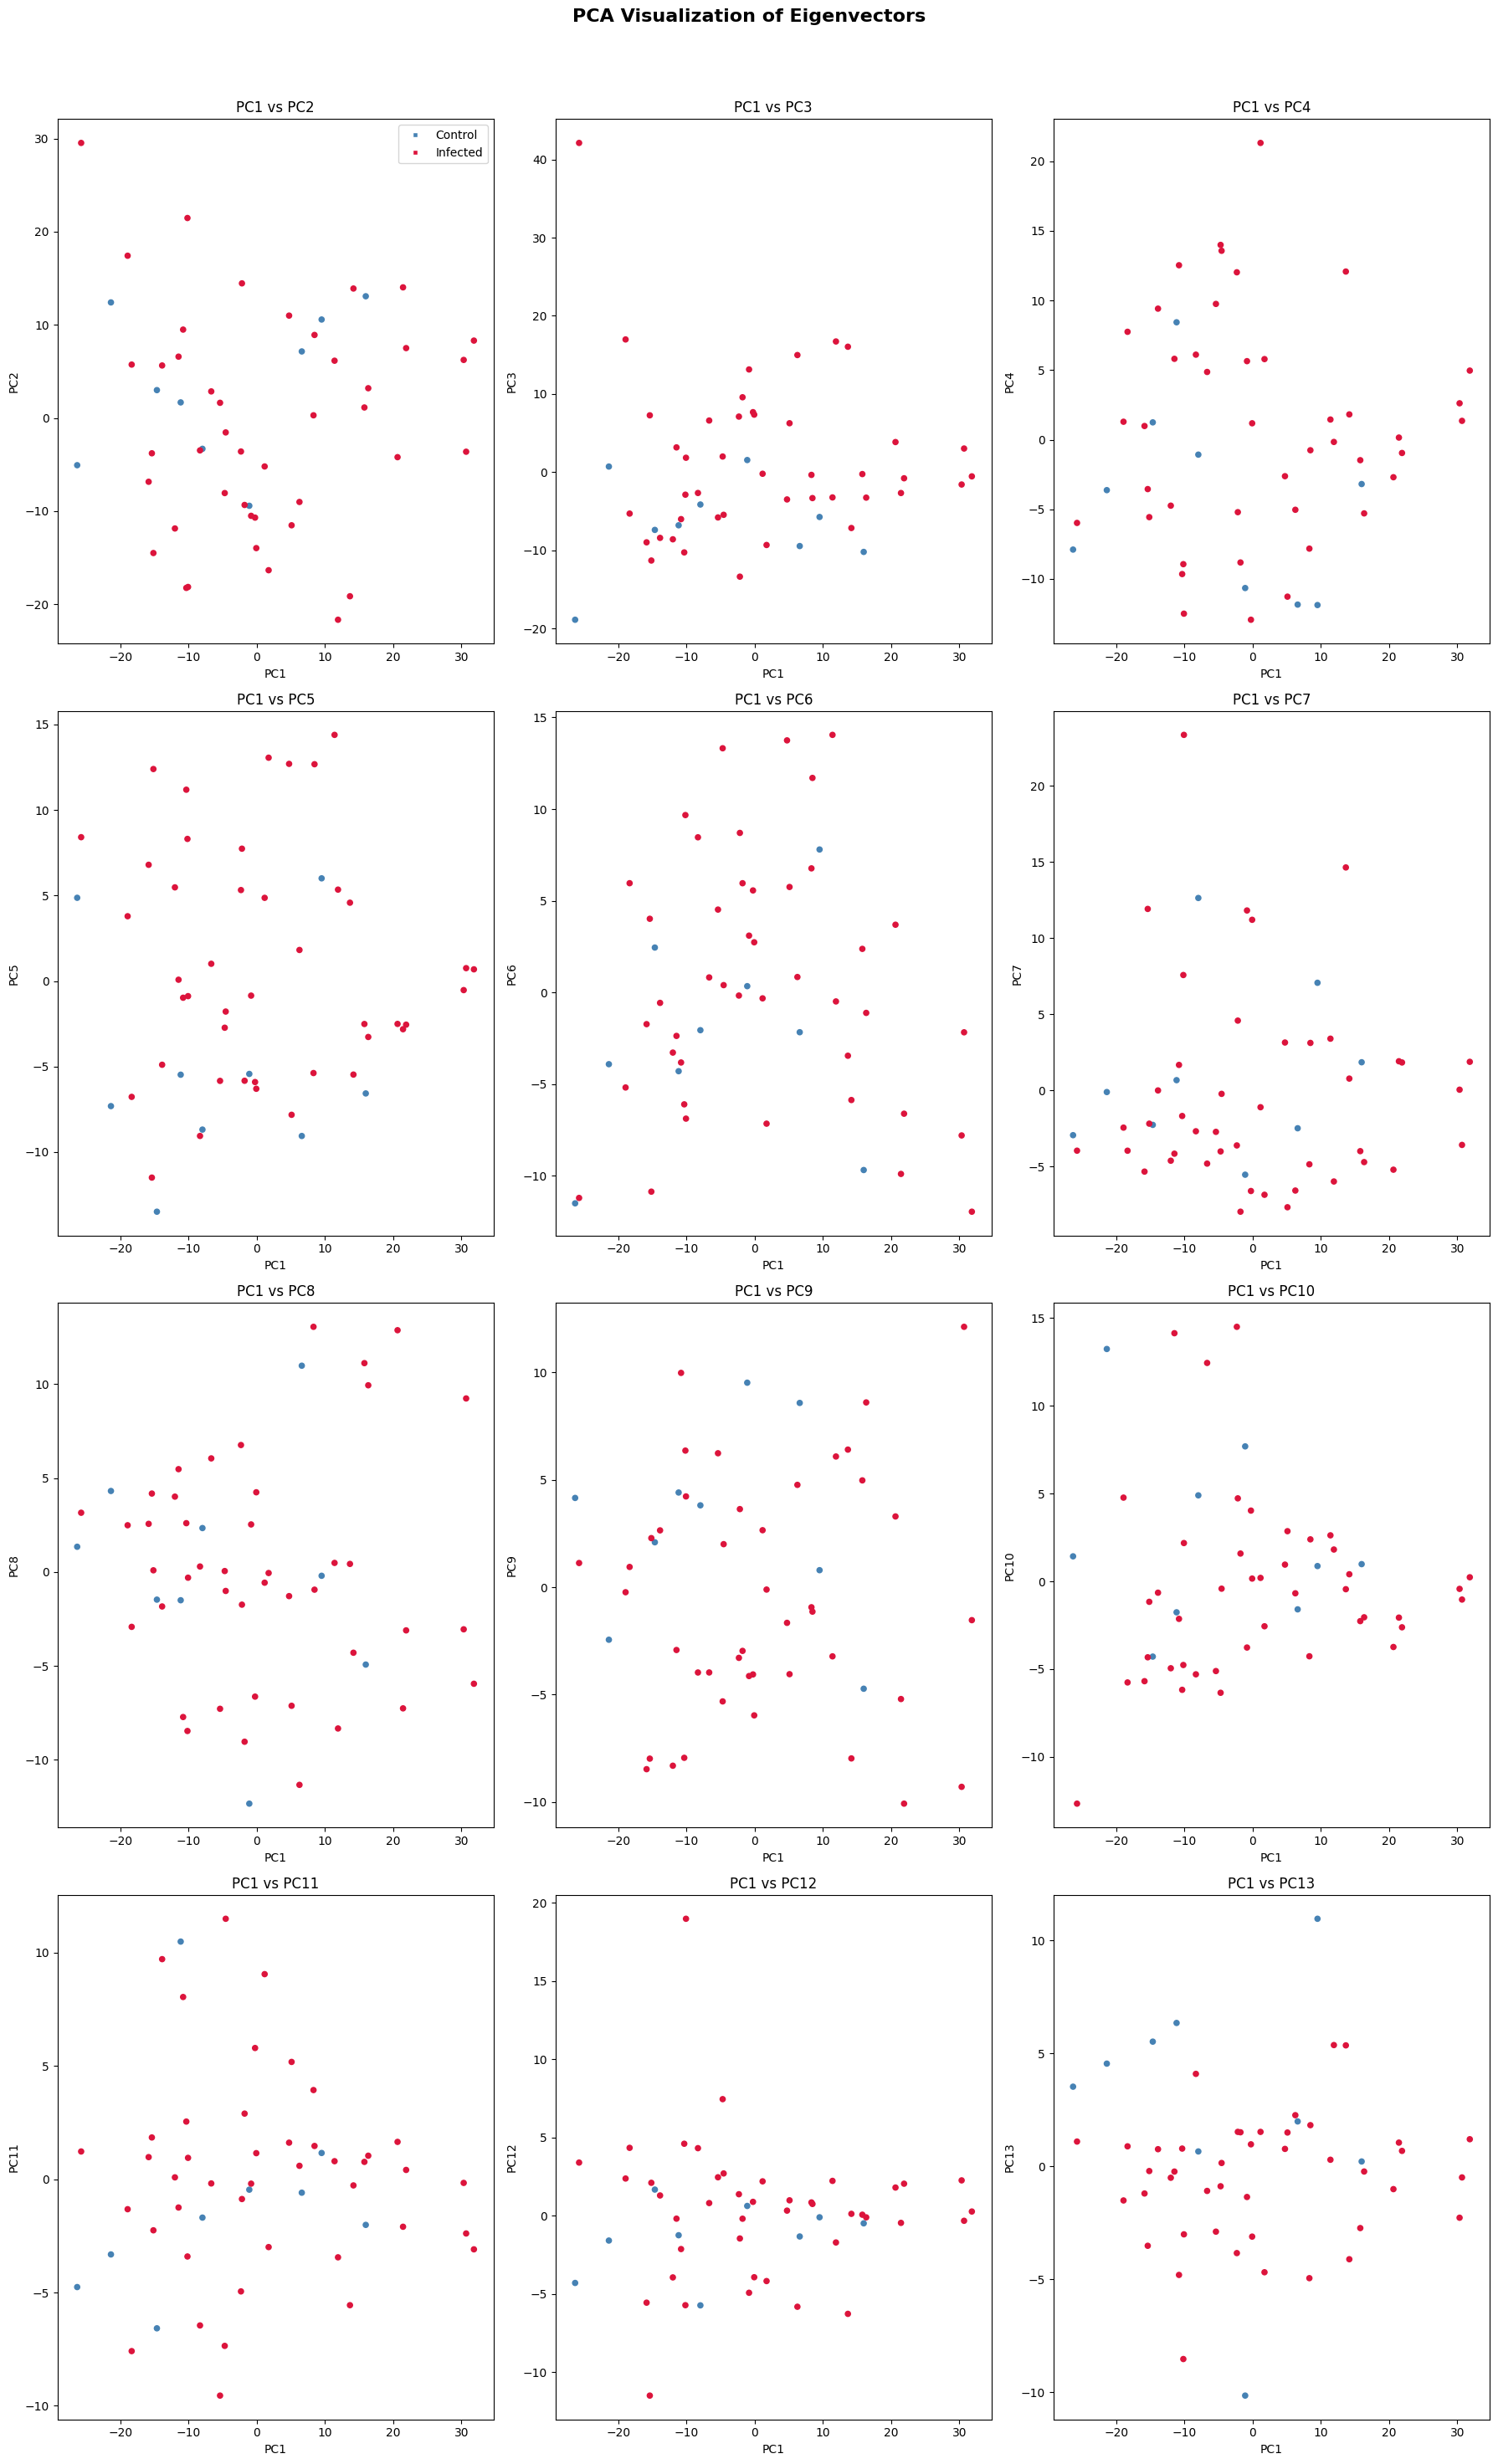

In [174]:
# Set up the grid for subplots (10 rows, 3 columns)
fig, axes = plt.subplots(4, 3, figsize=(18, 30))
fig.suptitle("PCA Visualization of Eigenvectors", fontweight='bold', fontsize=16)

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Loop to generate scatter plots from PC1 vs each PC up to PC30
for i in range(1, 13):
    ax = axes[i-1]
    ax.scatter(pca_results[:, 0], pca_results[:, i], c=colors, s=20)
    ax.set_title(f"PC1 vs PC{i+1}")
    ax.set_xlabel("PC1")
    ax.set_ylabel(f"PC{i+1}")

# Custom legend only in the first subplot (for cleanliness)
handles = [
    plt.Line2D([0], [0], marker='s', color='w', markerfacecolor='steelblue', markersize=5, label='Control'),
    plt.Line2D([0], [0], marker='s', color='w', markerfacecolor='crimson', markersize=5, label='Infected')
]
axes[0].legend(handles=handles)

# Hide any unused subplots (since there are only 29 plots for a 30-slot grid)
for j in range(29, len(axes)):
    axes[j].axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit title
plt.show()